# Equipo 3
-	Gutiérrez Pérez Gabriela G.
-	Loeza Saldaña Sebastián
-	Ramos García Luis Gerardo
-	Rico Mendoza Josué


# Resultados práctica anterior

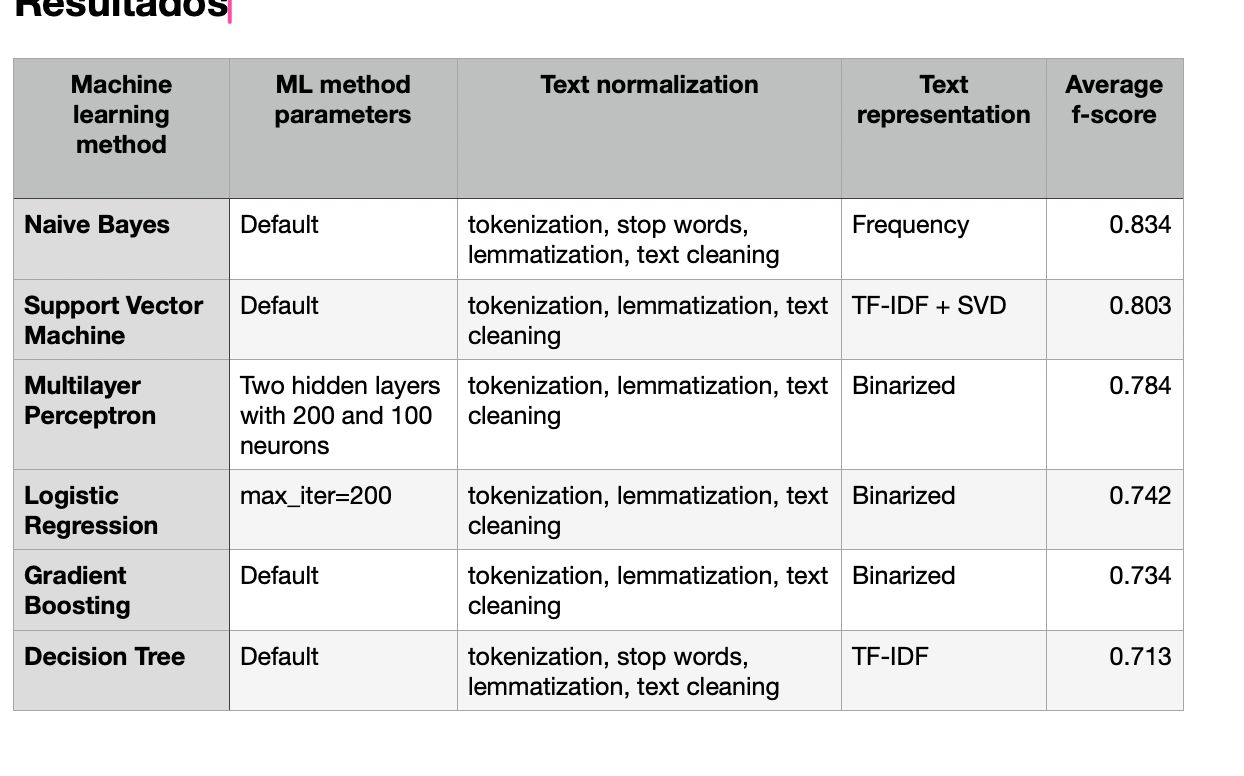

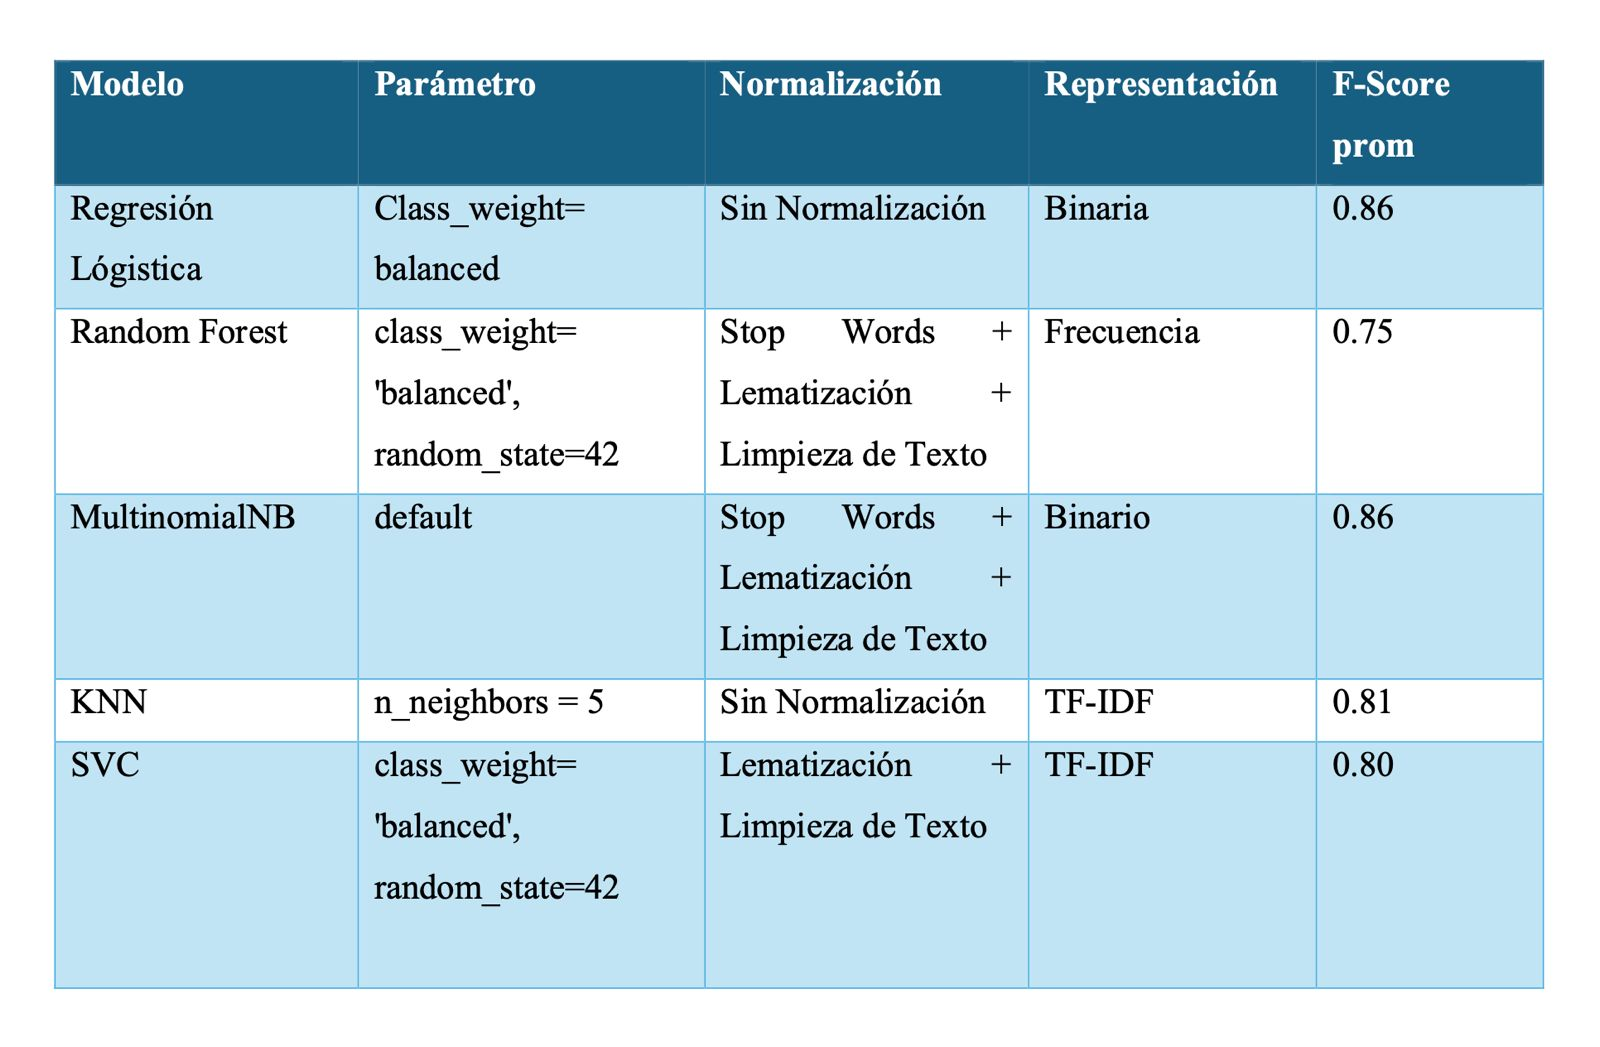

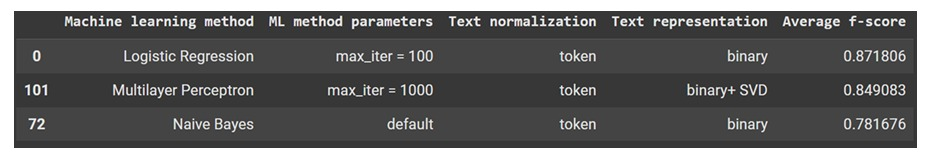

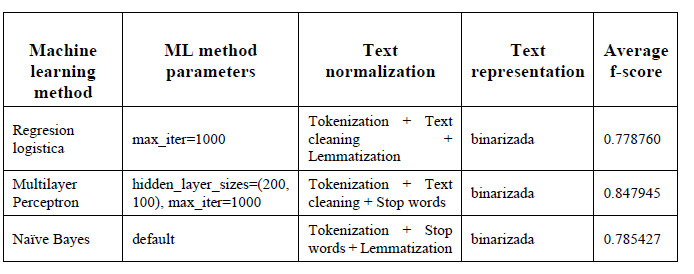

# Práctica 6 Sentiment analysis

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [ ]:
import pandas as pd
import numpy as np

#NLP
import spacy
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from scipy.sparse import hstack

#Regresión logística
from sklearn.linear_model import LogisticRegression

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

#Perceptron
from sklearn.neural_network import MLPClassifier

#Metricas
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


#Colab
import os
import os.path
from google.colab import files

#Balanceo
from sklearn.utils import resample

#Test
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 87.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Conjunto de datos Rest_Mex_2022

In [ ]:
#df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rest_Mex_2022.xlsx')
df = pd.read_excel('Rest_Mex_2022.xlsx')
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


## Conjunto de datos Emojis lexicon

In [ ]:
#emoji = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Emojis lexicon.XLSX')
emoji = pd.read_excel('Emojis lexicon.XLSX')
emoji.head()

,id,name,emoji,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,1,grinning face,😀,0.158667,0.555370,0.114186,0.192244,0.561993,0.186117,0.287942,0.596868,0.356135,0.976363
1,2,grinning face with big eyes,😃,0.172996,0.581902,0.136241,0.219991,0.603855,0.197681,0.304386,0.596117,0.385544,0.991735
2,3,grinning face with smiling eyes,😄,0.175038,0.517999,0.139511,0.189609,0.510113,0.180671,0.246538,0.528314,0.386087,0.885428
3,4,beaming face with smiling eyes,😁,0.174787,0.543446,0.122324,0.201830,0.539317,0.182929,0.280578,0.551692,0.371230,0.914501
4,5,grinning squinting face,😆,0.230904,0.461457,0.162243,0.235540,0.439998,0.212519,0.248078,0.486059,0.460756,0.799627


## Conjunto de datos Sel_full

In [ ]:
sel = pd.read_csv('SEL_full.txt', sep='\t')
sel.head()

,Palabra,Nula[%],Baja[%],Media[%],Alta[%],PFA,Categoría
0,abundancia,0,0,50,50,0.830,Alegría
1,acabalar,40,0,60,0,0.396,Alegría
2,acallar,50,40,10,0,0.198,Alegría
3,acatar,50,40,10,0,0.198,Alegría
4,acción,30,30,30,10,0.397,Alegría


## Creación del conjunto de datos

In [ ]:
df['Text'] = df['Title'].astype(str) + ' ' + df['Opinion'].astype(str)
df.head()

,Title,Opinion,Polarity,Attraction,Text
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel,Pésimo lugar Piensen dos veces antes de ir a e...
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant,No vayas a lugar de Eddie Cuatro de nosotros f...
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel,Mala relación calidad-precio seguiré corta y s...
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel,Minusválido? ¡No te alojes aquí! Al reservar u...
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel,Es una porqueria no pierdan su tiempo No pierd...


In [ ]:
df.drop(['Title', 'Opinion','Attraction'], axis=1, inplace=True)
df.head()

,Polarity,Text
0,1,Pésimo lugar Piensen dos veces antes de ir a e...
1,1,No vayas a lugar de Eddie Cuatro de nosotros f...
2,1,Mala relación calidad-precio seguiré corta y s...
3,1,Minusválido? ¡No te alojes aquí! Al reservar u...
4,1,Es una porqueria no pierdan su tiempo No pierd...


In [ ]:
polarity_counts = df['Polarity'].value_counts()
polarity_counts

,count
Polarity,
5,20936
4,5878
3,2121
2,730
1,547


## Normalización

### Diccionario de stop words

In [ ]:
Dic_StopWords = [
    # Artículos
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas',

    # Preposiciones
    'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante', 'en', 'entre', 'hacia', 'hasta', 'mediante',
    'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'versus', 'vía',

    # Conjunciones
    'y', 'e', 'ni', 'que', 'o', 'u', 'pero', 'mas', 'sino', 'aunque', 'si', 'como', 'porque', 'pues', 'ya', 'luego',
    'así', 'bien', 'sea', 'fuera', 'bien', 'cuando', 'donde'

    # Pronombres
    'yo', 'tú', 'él', 'ella', 'nosotros', 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'me', 'te', 'se', 'nos',
    'os', 'mi', 'mis', 'tu', 'tus', 'su', 'sus', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra',
    'vuestros', 'vuestras', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos',
    'suyas', 'le', 'les', 'lo', 'la', 'los', 'las', 'él', 'ella', 'ellos', 'ellas', 'esto', 'estos', 'esta', 'estas',
    'eso', 'esos', 'esa', 'esas', 'aquel', 'aquellos', 'aquella', 'aquellas', 'quien', 'quienes', 'cual', 'cuales',
    'cuya', 'cuyo', 'cuyas', 'cuyos'
]

### Funciones para la normalización

In [ ]:
# Función de tokenización que conserva todos los tokens

def tokenize_text(doc):
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

# Convertir el texto a minúsculas y eliminar caracteres no alfanuméricos
def TextCleaning(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Filtrar palabras que no estén en la lista de stop words
def StopWords(doc):

    return ' '.join([token.text for token in doc if token.text.lower() not in Dic_StopWords])

#  Extraer lemas de los tokens y concatenar en una cadena
def Lemmatization(doc):

    return ' '.join([token.lemma_ for token in doc])



### Función para el proceso de normalización con las diferentes variantes

In [ ]:
# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

def process_column(df, column_name):

    def combination(text):
        # Procesar el texto con spaCy
        doc = nlp(text)

        # Crear las 8 combinaciones como cadenas de texto
        result = {
            'Tokenization': tokenize_text(doc),

            'Tokenization + Text cleaning + Stop words': StopWords(nlp(TextCleaning(text))),

            'Tokenization + Text cleaning + Stop words + Lemmatization': Lemmatization(nlp(' '.join(StopWords(nlp(TextCleaning(text))).split())))
        }

        return result

    # Aplicar la función a cada fila de la columna
    processed_data = df[column_name].apply(combination)
    new_df = pd.DataFrame(processed_data.tolist())

    return new_df

### Crear dataset normalizado

La normalización toma al rededor de 45 min, por lo tanto las siguientes celdas solo es necesario ejecutarlas 1 vez.

En caso de que se cuente con un pkl, se puede hacer uso de él.

In [ ]:
#pkl_file_path = '/content/drive/MyDrive/Colab Notebooks/df_normalizado.pkl'
pkl_file_path = 'df_normalizado.pkl'
if os.path.exists(pkl_file_path):
  print("El pickle ya existe")

  with open(pkl_file_path, 'rb') as file:
    df_normalizado = pickle.load(file)

else:
  df_normalizado = process_column(df, 'Text')
  df_normalizado = pd.concat([df_normalizado, df['polarity']], axis=1)
  df_normalizado.to_pickle('df_normalizado.pkl')
  files.download('df_normalizado.pkl')

El pickle ya existe


In [ ]:
df_normalizado.shape

(30212, 3)

## Combinacion del df_normalizado con emojis lexicons

In [ ]:
def crear_diccionario_emojis(emoji_df):
    diccionario = {}
    for _, row in emoji_df.iterrows():
        emoji = row['emoji']  # Emoji como clave
        emociones = {col: row[col] for col in ['anger', 'anticipation', 'disgust', 'fear',
                                               'joy', 'sadness', 'surprise', 'trust',
                                               'negative', 'positive']}
        diccionario[emoji] = emociones
    return diccionario

def aplicar_emojis_por_columna(df_normalizado, emoji_diccionario):
    df_resultado = df_normalizado.copy()

    emociones = ['anger', 'anticipation', 'disgust', 'fear',
                 'joy', 'sadness', 'surprise', 'trust',
                 'negative', 'positive']

    for columna in df_normalizado.columns:
        resultados_emojis = []

        for texto in df_normalizado[columna]:
            conteo = {emocion: 0 for emocion in emociones}

            # Iterar directamente sobre los tokens en el texto
            tokens = texto.split() if isinstance(texto, str) else texto
            for token in tokens:
                if token in emoji_diccionario:
                    emociones_dict = emoji_diccionario[token]
                    for emocion, peso in emociones_dict.items():
                        conteo[emocion] += peso

            resultados_texto = [f"{emocion}: {valor:.2f}" for emocion, valor in conteo.items() if valor > 0]
            resultados_emojis.append("; ".join(resultados_texto))

        df_resultado[f"{columna}_emojis"] = resultados_emojis

    return df_resultado

In [ ]:
diccionario_emojis = crear_diccionario_emojis(emoji)
df_resultado_emojis = aplicar_emojis_por_columna(df_normalizado, diccionario_emojis)

In [ ]:
df_resultado_emojis.head(21)

,Tokenization,Tokenization + Text cleaning + Stop words,Tokenization + Text cleaning + Stop words + Lemmatization,Tokenization_emojis,Tokenization + Text cleaning + Stop words_emojis,Tokenization + Text cleaning + Stop words + Lemmatization_emojis
0,Pésimo lugar Piensen dos veces antes de ir a e...,Pésimo lugar Piensen dos veces antes ir este h...,pésimo lugar pensar dos vez antes ir este hote...,,,
1,No vayas a lugar de Eddie Cuatro de nosotros f...,No vayas lugar Eddie Cuatro fuimos recientemen...,no vayas lugar Eddie cuatro ir recientemente E...,,,
2,Mala relación calidad-precio seguiré corta y s...,Mala relación calidadprecio seguiré corta simp...,malo relación calidadprecio seguir corta simpl...,,,
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,Minusválido No alojes aquí Al reservar hotel m...,Minusválido no aloj aquí Al reservar hotel mul...,,,
4,Es una porqueria no pierdan su tiempo No pierd...,Es porqueria no pierdan tiempo No pierdan tiem...,ser porquerio no perder tiempo no perder tiemp...,,,
5,El peor huevos Benedict jamás Hoy teníamos el ...,peor huevos Benedict jamás Hoy teníamos desayu...,peor huevo Benedict jamás hoy tener desayuno s...,,,
6,Definitivamente no volvería a hospedarme en Sa...,Definitivamente no volvería hospedarme Samba V...,Definitivamente no volver hospedarme Samba Val...,,,
7,Terrible No estoy seguro de por qué este resta...,Terrible No estoy seguro este restaurante tien...,Terrible no estar seguro este restaurante tene...,,,
8,"Bebidas ADULTERADAS , FATAL mi experiencia ! !...",Bebidas ADULTERADAS FATAL mi experiencia Llegu...,Bebidas ADULTERADAS FATAL mi experiencia Llegu...,,,
9,Hotel ha ido cuesta abajo Hemos estado viniend...,Hotel ha ido cuesta abajo Hemos estado viniend...,Hotel haber ir costar abajo Hemos estar venir ...,,,


## Combinacion del df_normalizado con sel_full

### Versión acumulado por cada emoción

In [ ]:
# Revisar si el pickle existe
#pkl_file_path = '/content/drive/MyDrive/Colab Notebooks/df_sel.pkl'
pkl_file_path = 'df_sel.pkl'

if os.path.exists(pkl_file_path):
  print("El pickle ya existe")

  with open(pkl_file_path, 'rb') as file:
    df_sel = pickle.load(file)

else:

  df_sel = df_normalizado.copy()

  categorias = sel["Categoría"].unique()
  for categoria in categorias:
      df_sel[categoria] = 0

  # Función para calcular la puntuación de una palabra
  def calcular_puntuacion(row):
      return row['Nula[%]']*0 + row["Baja[%]"] + row["Media[%]"] * 2 + row["Alta[%]"] * 3

  # Añadir una columna de puntuación al df_palabras
  sel["Puntuación"] = sel.apply(calcular_puntuacion, axis=1)

  # Procesar las opiniones
  def puntuar_opinion(opinion):
      puntuaciones = {categoria: 0 for categoria in categorias}

      # Limpiar y dividir la opinión en palabras
      palabras_opinion = ''.join(
          [c if c.isalnum() or c.isspace() else ' ' for c in opinion.lower()]
      ).split()

      for palabra in palabras_opinion:
          coincidencias = sel[sel["Palabra"].str.lower() == palabra.lower()]
          for _, row in coincidencias.iterrows():
              puntuaciones[row["Categoría"]] += row["Puntuación"]

      return puntuaciones


  # Calcular las puntuaciones para cada opinión
  df_sel[[categoria for categoria in categorias]] = df_sel["Tokenization"].apply(
      lambda x: pd.Series(puntuar_opinion(x))
  )
  df_sel['Polarity'] = df['Polarity']
  df_sel.to_pickle('df_sel.pkl')
  files.download('df_sel.pkl')

df_sel.head(10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Tokenization,Tokenization + Text cleaning + Stop words,Tokenization + Text cleaning + Stop words + Lemmatization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza
0,Pésimo lugar Piensen dos veces antes de ir a e...,Pésimo lugar Piensen dos veces antes ir este h...,pésimo lugar pensar dos vez antes ir este hote...,240,0,0,190,0,0
1,No vayas a lugar de Eddie Cuatro de nosotros f...,No vayas lugar Eddie Cuatro fuimos recientemen...,no vayas lugar Eddie cuatro ir recientemente E...,0,0,270,180,200,300
2,Mala relación calidad-precio seguiré corta y s...,Mala relación calidadprecio seguiré corta simp...,malo relación calidadprecio seguir corta simpl...,0,0,0,0,0,0
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,Minusválido No alojes aquí Al reservar hotel m...,Minusválido no aloj aquí Al reservar hotel mul...,170,0,0,0,290,0
4,Es una porqueria no pierdan su tiempo No pierd...,Es porqueria no pierdan tiempo No pierdan tiem...,ser porquerio no perder tiempo no perder tiemp...,120,0,0,0,50,190
5,El peor huevos Benedict jamás Hoy teníamos el ...,peor huevos Benedict jamás Hoy teníamos desayu...,peor huevo Benedict jamás hoy tener desayuno s...,270,0,520,230,130,80
6,Definitivamente no volvería a hospedarme en Sa...,Definitivamente no volvería hospedarme Samba V...,Definitivamente no volver hospedarme Samba Val...,570,170,200,0,80,300
7,Terrible No estoy seguro de por qué este resta...,Terrible No estoy seguro qué este restaurante ...,Terrible no estar seguro qué este restaurante ...,140,0,270,190,0,0
8,"Bebidas ADULTERADAS , FATAL mi experiencia ! !...",Bebidas ADULTERADAS FATAL experiencia Llegué e...,Bebidas ADULTERADAS FATAL experiencia Llegué e...,240,0,190,0,0,250
9,Hotel ha ido cuesta abajo Hemos estado viniend...,Hotel ha ido cuesta abajo Hemos estado viniend...,Hotel haber ir costar abajo Hemos estar venir ...,210,0,0,0,0,0


### Versión PFA acumulado positivo y negativo

####Creación de las nuevas dimensiones


In [ ]:
def load_sel():
	#~ global lexicon_sel
	lexicon_sel = {}
	input_file = open('SEL_full.txt', 'r')
	for line in input_file:
		#Las líneas del lexicon tienen el siguiente formato:
		#abundancia	0	0	50	50	0.83	Alegría

		palabras = line.split("\t")
		palabras[6]= re.sub('\n', '', palabras[6])
		pair = (palabras[6], palabras[5])
		if lexicon_sel:
			if palabras[0] not in lexicon_sel:
				lista = [pair]
				lexicon_sel[palabras[0]] = lista
			else:
				lexicon_sel[palabras[0]].append (pair)

		else:
			lista = [pair]
			lexicon_sel[palabras[0]] = lista
	input_file.close()
	del lexicon_sel['Palabra']; #Esta llave se inserta porque es parte del encabezado del diccionario, por lo que se requiere eliminar
	#Estructura resultante
		#'hastiar': [('Enojo\n', '0.629'), ('Repulsi\xf3n\n', '0.596')]
	return lexicon_sel


In [ ]:
def getSELFeatures(cadenas, lexicon_sel):
	#'hastiar': [('Enojo\n', '0.629'), ('Repulsi\xf3n\n', '0.596')]
	features = []
	for cadena in cadenas:
		valor_alegria = 0.0
		valor_enojo = 0.0
		valor_miedo = 0.0
		valor_repulsion = 0.0
		valor_sorpresa = 0.0
		valor_tristeza = 0.0
		cadena_palabras = re.split('\s+', cadena)
		dic = {}
		for palabra in cadena_palabras:
			if palabra in lexicon_sel:
				caracteristicas = lexicon_sel[palabra]
				for emocion, valor in caracteristicas:

					if emocion == 'Sorpresa':
						valor_sorpresa = valor_sorpresa + float(valor)
					elif emocion == 'Tristeza':
						valor_tristeza = valor_tristeza + float(valor)
					elif emocion == 'Enojo':
						valor_enojo = valor_enojo + float(valor)
					elif emocion == 'Repulsión':
						valor_repulsion = valor_repulsion + float(valor)
					elif emocion == 'Miedo':
						valor_miedo = valor_miedo + float(valor)
					elif emocion == 'Alegría':

						valor_alegria = valor_alegria + float(valor)
					else:
						valor_alegria = valor_alegria + float(valor)

		dic['__alegría__'] = valor_alegria
		dic['__tristeza__'] = valor_tristeza
		dic['__enojo__'] = valor_enojo
		dic['__repulsion__'] = valor_repulsion
		dic['__miedo__'] = valor_miedo
		dic['__sorpresa__'] = valor_sorpresa

		#Esto es para los valores acumulados del mapeo a positivo (alegría + sorpresa) y negativo (enojo + miedo + repulsión + tristeza)
		dic['acumuladopositivo'] = dic['__alegría__'] + dic['__sorpresa__']
		dic['acumuladonegative'] = dic['__enojo__'] + dic['__miedo__'] + dic['__repulsion__'] + dic['__tristeza__']

		features.append (dic)
	return features

Este proceso es tradado por lo que si ya se cuenta con un pkl se puede hacer uso de él.

In [ ]:
if os.path.exists('lexicon_sel.pkl'):
    with open('lexicon_sel.pkl', 'rb') as file:
        lexicon_sel = pickle.load(file)
else:
    lexicon_sel = load_sel()
    with open('lexicon_sel.pkl', 'wb') as file:
        pickle.dump(lexicon_sel, file)


#### Para tokenizacion (logistica)

In [ ]:
def calcular_polaridades(cadena):
    # Usamos el método del código 1 para obtener las características emocionales
    features = getSELFeatures([cadena], lexicon_sel)
    # Extraemos los valores acumulativos positivo y negativo
    acumulativo_positivo = features[0]['acumuladopositivo']
    acumulativo_negativo = features[0]['acumuladonegative']
    return acumulativo_positivo, acumulativo_negativo

# Aplicamos la función a cada fila y almacenamos los resultados
df_normalizado[['AcumulativoPositivo', 'AcumulativoNegativo']] = df_normalizado['Tokenization'].apply(
    lambda cadena: pd.Series(calcular_polaridades(cadena))
)

# Mostramos el nuevo DataFrame con las columnas requeridas
df_resultado_polaridad_logistica = df_normalizado[['Tokenization', 'AcumulativoPositivo', 'AcumulativoNegativo']]
df_resultado_polaridad_logistica['Polarity'] = df['Polarity']
df_resultado_polaridad_logistica

<ipython-input-99-1eb43427f5e5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_polaridad_logistica['Polarity'] = df['Polarity']


,Tokenization,AcumulativoPositivo,AcumulativoNegativo,Polarity
0,Pésimo lugar Piensen dos veces antes de ir a e...,0.792,0.000,1
1,No vayas a lugar de Eddie Cuatro de nosotros f...,0.660,2.489,1
2,Mala relación calidad-precio seguiré corta y s...,0.000,0.000,1
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,1.529,0.000,1
4,Es una porqueria no pierdan su tiempo No pierd...,0.561,0.629,1
...,...,...,...,...
30207,Verdadera joya arquitectónica Es una construcc...,0.763,0.000,5
30208,Romántico Muy al estilo de Romeo y Julieta es ...,0.630,0.000,5
30209,Parece un castillo Ideal para subir las escali...,0.000,0.000,5
30210,"Imperdible Es imperdible , de ahí puedes ver m...",1.263,0.000,5


Creacion del PKL en caso de ser la ejecucion por primera vez

In [ ]:
df_resultado_polaridad_logistica.to_pickle('df_resultado_polaridad_logistica.pkl')

#### Tokenization + Text cleaning + Stop words + Lemmatization (Naive)

In [ ]:
def calcular_polaridades(cadena):
    # Usamos el método del código 1 para obtener las características emocionales
    features = getSELFeatures([cadena], lexicon_sel)
    # Extraemos los valores acumulativos positivo y negativo
    acumulativo_positivo = features[0]['acumuladopositivo']
    acumulativo_negativo = features[0]['acumuladonegative']
    return acumulativo_positivo, acumulativo_negativo

# Aplicamos la función a cada fila y almacenamos los resultados
df_normalizado[['AcumulativoPositivo', 'AcumulativoNegativo']] = df_normalizado['Tokenization + Text cleaning + Stop words + Lemmatization'].apply(
    lambda cadena: pd.Series(calcular_polaridades(cadena))
)

# Mostramos el nuevo DataFrame con las columnas requeridas
df_resultado_polaridad_naive = df_normalizado[['Tokenization + Text cleaning + Stop words + Lemmatization', 'AcumulativoPositivo', 'AcumulativoNegativo']]
df_resultado_polaridad_naive['Polarity'] = df['Polarity']
df_resultado_polaridad_naive

<ipython-input-101-867cb0835fb4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_polaridad_naive['Polarity'] = df['Polarity']


,Tokenization + Text cleaning + Stop words + Lemmatization,AcumulativoPositivo,AcumulativoNegativo,Polarity
0,pésimo lugar pensar dos vez antes ir este hote...,0.792,3.151,1
1,no vayas lugar Eddie cuatro ir recientemente E...,0.660,3.611,1
2,malo relación calidadprecio seguir corta simpl...,0.000,1.489,1
3,Minusválido no aloj aquí Al reservar hotel mul...,2.354,0.000,1
4,ser porquerio no perder tiempo no perder tiemp...,0.561,3.380,1
...,...,...,...,...
30207,Verdadera joya arquitectónico ser construcción...,0.763,0.000,5
30208,Romántico mucho al estilo Romeo Julieta ser es...,0.630,0.000,5
30209,parecer castillo Ideal subir escalinata divisa...,0.000,0.000,5
30210,Imperdible ser imperdible ahí poder ver mucho ...,0.795,0.000,5


Creacion del PKL en caso de ser la ejecucion por primera vez

In [ ]:
df_resultado_polaridad_naive.to_pickle('df_resultado_polaridad_naive.pkl')

#### Para Tokenization + Text cleaning + Stop words (Perceptron)

In [ ]:
def calcular_polaridades(cadena):
    # Usamos el método del código 1 para obtener las características emocionales
    features = getSELFeatures([cadena], lexicon_sel)
    # Extraemos los valores acumulativos positivo y negativo
    acumulativo_positivo = features[0]['acumuladopositivo']
    acumulativo_negativo = features[0]['acumuladonegative']
    return acumulativo_positivo, acumulativo_negativo

# Aplicamos la función a cada fila y almacenamos los resultados
df_normalizado[['AcumulativoPositivo', 'AcumulativoNegativo']] = df_normalizado['Tokenization + Text cleaning + Stop words'].apply(
    lambda cadena: pd.Series(calcular_polaridades(cadena))
)

# Mostramos el nuevo DataFrame con las columnas requeridas
df_resultado_polaridad_perceptron = df_normalizado[['Tokenization + Text cleaning + Stop words', 'AcumulativoPositivo', 'AcumulativoNegativo']]
df_resultado_polaridad_perceptron['Polarity'] = df['Polarity']
df_resultado_polaridad_perceptron

<ipython-input-103-1b885b3f30d8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_polaridad_perceptron['Polarity'] = df['Polarity']


,Tokenization + Text cleaning + Stop words,AcumulativoPositivo,AcumulativoNegativo,Polarity
0,Pésimo lugar Piensen dos veces antes ir este h...,0.792,0.000,1
1,No vayas lugar Eddie Cuatro fuimos recientemen...,0.660,2.489,1
2,Mala relación calidadprecio seguiré corta simp...,0.000,0.000,1
3,Minusválido No alojes aquí Al reservar hotel m...,1.529,0.000,1
4,Es porqueria no pierdan tiempo No pierdan tiem...,0.561,0.629,1
...,...,...,...,...
30207,Verdadera joya arquitectónica Es construcción ...,0.763,0.000,5
30208,Romántico Muy al estilo Romeo Julieta es este ...,0.630,0.000,5
30209,Parece castillo Ideal subir escalinatas divisa...,0.000,0.000,5
30210,Imperdible Es imperdible ahí puedes ver muy ci...,0.465,0.000,5


Creacion del PKL en caso de ser la ejecucion por primera vez

In [ ]:
df_resultado_polaridad_perceptron.to_pickle('df_resultado_polaridad_perceptron.pkl')

##Balanceo (Undersampling)

###Para logística (solo tokenizado)

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/df_normalizado.pkl', 'rb')
with open('df_normalizado.pkl', 'rb') as f:
  df_normalizado = pickle.load(f)

df_normalizado.head()

,Tokenization,Tokenization + Text cleaning + Stop words,Tokenization + Text cleaning + Stop words + Lemmatization,Polarity
0,Pésimo lugar Piensen dos veces antes de ir a e...,Pésimo lugar Piensen dos veces antes ir este h...,pésimo lugar pensar dos vez antes ir este hote...,1
1,No vayas a lugar de Eddie Cuatro de nosotros f...,No vayas lugar Eddie Cuatro fuimos recientemen...,no vayas lugar Eddie cuatro ir recientemente E...,1
2,Mala relación calidad-precio seguiré corta y s...,Mala relación calidadprecio seguiré corta simp...,malo relación calidadprecio seguir corta simpl...,1
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,Minusválido No alojes aquí Al reservar hotel m...,Minusválido no aloj aquí Al reservar hotel mul...,1
4,Es una porqueria no pierdan su tiempo No pierd...,Es porqueria no pierdan tiempo No pierdan tiem...,ser porquerio no perder tiempo no perder tiemp...,1


In [ ]:
X = df_normalizado.drop(['Tokenization + Text cleaning + Stop words', 'Tokenization + Text cleaning + Stop words + Lemmatization',
                         'Polarity'], axis=1)
y = df_normalizado['Polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle = True) # Use stratify for balanced split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


train_df = pd.concat([X_train, y_train], axis=1)
test_df_log_norm = pd.concat([X_test, y_test], axis=1)

print("\nTrain DataFrame:")
train_df.head()

X_train shape: (24169, 1)
X_test shape: (6043, 1)
y_train shape: (24169,)
y_test shape: (6043,)

Train DataFrame:


,Tokenization,Polarity
18594,El mejor también en el lockdown También ahora ...,5
19690,Vacaciones con mi esposo Desde que llegamos al...,5
26183,Super Bowl Excelente servicio y ponen el súper...,5
26029,Rico y abundante Excelente los desayunos muy a...,5
16566,Tratamiento de spa Tuvimos un masaje de 80 min...,5


In [ ]:
print("\nTest DataFrame:")
test_df_log_norm.head()


Test DataFrame:


,Tokenization,Polarity
9730,Gran cena con fuegos artificiales después ! La...,5
7442,Vacaciones en familia en general estupendo Nos...,4
25844,Vacaciones Gran lugar para comer ! Camarón azu...,5
9565,lugar romantico para llevar a tu pareja buena ...,5
718,Ejecución inconsistente cocina Cenamos dos vec...,2


Solo se balancea el conjunto de entrenamiento

In [ ]:
# Ver distribución inicial
print("Distribución inicial:")
print(train_df['Polarity'].value_counts())

# Identificar la clase minoritaria
min_count = train_df['Polarity'].value_counts().min()

# Realizar undersampling
df_balanced = pd.concat(
    [resample(train_df[train_df['Polarity'] == label],
              replace=False,  # Sin reemplazo
              n_samples=min_count,  # Balancear al tamaño de la clase minoritaria
              random_state=0)
     for label in train_df['Polarity'].unique()]
)

# Ver distribución balanceada
print("\nDistribución después del undersampling:")
print(df_balanced['Polarity'].value_counts())

# Mostrar el DataFrame balanceado
df_balanced.head()

Distribución inicial:
Polarity
5    16727
4     4715
3     1699
2      585
1      443
Name: count, dtype: int64

Distribución después del undersampling:
Polarity
5    443
4    443
2    443
3    443
1    443
Name: count, dtype: int64


,Tokenization,Polarity
21814,Vacaciones de verano Los chicos de joy squad e...,5
28475,Espacio muuuy familiar y rico para disfrutar E...,5
20521,La mejor experiencia Excelente servicio de tod...,5
18543,Excelente servicio Cena en omaggio muy buena v...,5
18152,Buena comida a un precio estupendo ! Tuvimos u...,5


### Para logística (con SEL en acumulado Positivo y Negativo)

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/df_resultado_polaridad_logistica.pkl', 'rb') as f:
with open('df_resultado_polaridad_logistica.pkl', 'rb') as f:
  df_sel_log = pickle.load(f)

df_sel_log.head()

,Tokenization,AcumulativoPositivo,AcumulativoNegativo,Polarity
0,Pésimo lugar Piensen dos veces antes de ir a e...,0.792,0.000,1
1,No vayas a lugar de Eddie Cuatro de nosotros f...,0.660,2.489,1
2,Mala relación calidad-precio seguiré corta y s...,0.000,0.000,1
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,1.529,0.000,1
4,Es una porqueria no pierdan su tiempo No pierd...,0.561,0.629,1


In [ ]:
X = df_sel_log.drop(['Polarity'], axis=1)
y = df_sel_log['Polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle = True) # Use stratify for balanced split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


train_df = pd.concat([X_train, y_train], axis=1)
test_df_log_sel = pd.concat([X_test, y_test], axis=1)

print("\nTrain DataFrame:")
train_df.head()

X_train shape: (24169, 3)
X_test shape: (6043, 3)
y_train shape: (24169,)
y_test shape: (6043,)

Train DataFrame:


,Tokenization,AcumulativoPositivo,AcumulativoNegativo,Polarity
18594,El mejor también en el lockdown También ahora ...,1.290,1.754,5
19690,Vacaciones con mi esposo Desde que llegamos al...,0.000,0.099,5
26183,Super Bowl Excelente servicio y ponen el súper...,1.127,0.099,5
26029,Rico y abundante Excelente los desayunos muy a...,0.000,0.000,5
16566,Tratamiento de spa Tuvimos un masaje de 80 min...,0.000,0.000,5


In [ ]:
print("\nTest DataFrame:")
test_df_log_sel.head()


Test DataFrame:


,Tokenization,AcumulativoPositivo,AcumulativoNegativo,Polarity
9730,Gran cena con fuegos artificiales después ! La...,0.763,0.000,5
7442,Vacaciones en familia en general estupendo Nos...,1.794,1.891,4
25844,Vacaciones Gran lugar para comer ! Camarón azu...,0.000,0.000,5
9565,lugar romantico para llevar a tu pareja buena ...,0.132,0.729,5
718,Ejecución inconsistente cocina Cenamos dos vec...,5.116,0.663,2


In [ ]:
# Ver distribución inicial
print("Distribución inicial:")
print(train_df['Polarity'].value_counts())

# Identificar la clase minoritaria
min_count = train_df['Polarity'].value_counts().min()

# Realizar undersampling
df_balanced_log_sel = pd.concat(
    [resample(train_df[train_df['Polarity'] == label],
              replace=False,  # Sin reemplazo
              n_samples=min_count,  # Balancear al tamaño de la clase minoritaria
              random_state=0)
     for label in train_df['Polarity'].unique()]
)

# Ver distribución balanceada
print("\nDistribución después del undersampling:")
print(df_balanced_log_sel['Polarity'].value_counts())

# Mostrar el DataFrame balanceado
df_balanced_log_sel.head()

Distribución inicial:
Polarity
5    16727
4     4715
3     1699
2      585
1      443
Name: count, dtype: int64

Distribución después del undersampling:
Polarity
5    443
4    443
2    443
3    443
1    443
Name: count, dtype: int64


,Tokenization,AcumulativoPositivo,AcumulativoNegativo,Polarity
21814,Vacaciones de verano Los chicos de joy squad e...,0.763,0.000,5
28475,Espacio muuuy familiar y rico para disfrutar E...,3.088,0.000,5
20521,La mejor experiencia Excelente servicio de tod...,0.000,0.000,5
18543,Excelente servicio Cena en omaggio muy buena v...,1.165,0.000,5
18152,Buena comida a un precio estupendo ! Tuvimos u...,4.021,0.099,5


### Para logística (acumulado por cada emoción)

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/df_sel.pkl', 'rb')
with open('df_sel.pkl', 'rb') as f:
  df_sel_cum = pickle.load(f)

df_sel_cum.head()

,Tokenization,Tokenization + Text cleaning + Stop words,Tokenization + Text cleaning + Stop words + Lemmatization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza,Polarity
0,Pésimo lugar Piensen dos veces antes de ir a e...,Pésimo lugar Piensen dos veces antes ir este h...,pésimo lugar pensar dos vez antes ir este hote...,240,0,0,190,0,0,1
1,No vayas a lugar de Eddie Cuatro de nosotros f...,No vayas lugar Eddie Cuatro fuimos recientemen...,no vayas lugar Eddie cuatro ir recientemente E...,0,0,270,180,200,300,1
2,Mala relación calidad-precio seguiré corta y s...,Mala relación calidadprecio seguiré corta simp...,malo relación calidadprecio seguir corta simpl...,0,0,0,0,0,0,1
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,Minusválido No alojes aquí Al reservar hotel m...,Minusválido no aloj aquí Al reservar hotel mul...,170,0,0,0,290,0,1
4,Es una porqueria no pierdan su tiempo No pierd...,Es porqueria no pierdan tiempo No pierdan tiem...,ser porquerio no perder tiempo no perder tiemp...,120,0,0,0,50,190,1


In [ ]:
X = df_sel_cum.drop(['Polarity','Tokenization + Text cleaning + Stop words',
                     'Tokenization + Text cleaning + Stop words + Lemmatization'], axis=1)
y = df_sel_cum['Polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle = True) # Use stratify for balanced split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


train_df = pd.concat([X_train, y_train], axis=1)
test_df_sel_cum = pd.concat([X_test, y_test], axis=1)

print("\nTrain DataFrame:")
train_df.head()

X_train shape: (24169, 7)
X_test shape: (6043, 7)
y_train shape: (24169,)
y_test shape: (6043,)

Train DataFrame:


,Tokenization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza,Polarity
18594,El mejor también en el lockdown También ahora ...,310,0,100,0,80,430,5
19690,Vacaciones con mi esposo Desde que llegamos al...,0,0,30,0,0,0,5
26183,Super Bowl Excelente servicio y ponen el súper...,460,0,30,0,110,0,5
26029,Rico y abundante Excelente los desayunos muy a...,230,0,0,0,0,0,5
16566,Tratamiento de spa Tuvimos un masaje de 80 min...,0,0,0,0,0,0,5


In [ ]:
print("\nTest DataFrame:")
test_df_sel_cum.head()


Test DataFrame:


,Tokenization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza,Polarity
9730,Gran cena con fuegos artificiales después ! La...,230,0,0,0,0,0,5
7442,Vacaciones en familia en general estupendo Nos...,260,0,0,180,280,390,4
25844,Vacaciones Gran lugar para comer ! Camarón azu...,0,0,0,0,0,0,5
9565,lugar romantico para llevar a tu pareja buena ...,0,0,0,0,40,220,5
718,Ejecución inconsistente cocina Cenamos dos vec...,1540,0,30,0,0,170,2


In [ ]:
# Ver distribución inicial
print("Distribución inicial:")
print(train_df['Polarity'].value_counts())

# Identificar la clase minoritaria
min_count = train_df['Polarity'].value_counts().min()

# Realizar undersampling
df_balanced_sel_cum = pd.concat(
    [resample(train_df[train_df['Polarity'] == label],
              replace=False,  # Sin reemplazo
              n_samples=min_count,  # Balancear al tamaño de la clase minoritaria
              random_state=0)
     for label in train_df['Polarity'].unique()]
)

# Ver distribución balanceada
print("\nDistribución después del undersampling:")
print(df_balanced_sel_cum['Polarity'].value_counts())

# Mostrar el DataFrame balanceado
df_balanced_sel_cum.head()

Distribución inicial:
Polarity
5    16727
4     4715
3     1699
2      585
1      443
Name: count, dtype: int64

Distribución después del undersampling:
Polarity
5    443
4    443
2    443
3    443
1    443
Name: count, dtype: int64


,Tokenization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza,Polarity
21814,Vacaciones de verano Los chicos de joy squad e...,230,0,0,0,0,0,5
28475,Espacio muuuy familiar y rico para disfrutar E...,930,0,0,0,0,0,5
20521,La mejor experiencia Excelente servicio de tod...,230,0,0,0,0,0,5
18543,Excelente servicio Cena en omaggio muy buena v...,530,0,0,0,50,0,5
18152,Buena comida a un precio estupendo ! Tuvimos u...,1000,0,30,0,210,0,5


### Para perceptron (con SEL en acumulado positivo y negativo)

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/df_resultado_polaridad_perceptron.pkl', 'rb')
with open('df_resultado_polaridad_perceptron.pkl', 'rb') as f:
  df_sel_percep = pickle.load(f)

df_sel_percep.head()

,Tokenization + Text cleaning + Stop words,AcumulativoPositivo,AcumulativoNegativo,Polarity
0,Pésimo lugar Piensen dos veces antes ir este h...,0.792,0.000,1
1,No vayas lugar Eddie Cuatro fuimos recientemen...,0.660,2.489,1
2,Mala relación calidadprecio seguiré corta simp...,0.000,0.000,1
3,Minusválido No alojes aquí Al reservar hotel m...,1.529,0.000,1
4,Es porqueria no pierdan tiempo No pierdan tiem...,0.561,0.629,1


In [ ]:
X = df_sel_percep.drop(['Polarity'], axis=1)
y = df_sel_percep['Polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle = True) # Use stratify for balanced split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


train_df = pd.concat([X_train, y_train], axis=1)
test_df_percep_sel = pd.concat([X_test, y_test], axis=1)

print("\nTrain DataFrame:")
train_df.head()

X_train shape: (24169, 3)
X_test shape: (6043, 3)
y_train shape: (24169,)
y_test shape: (6043,)

Train DataFrame:


,Tokenization + Text cleaning + Stop words,AcumulativoPositivo,AcumulativoNegativo,Polarity
18594,mejor también lockdown También ahora abiertos ...,0.528,1.754,5
19690,Vacaciones esposo llegamos al hotel personal e...,0.000,0.099,5
26183,Super Bowl Excelente servicio ponen súper tazó...,1.127,0.099,5
26029,Rico abundante Excelente desayunos muy abundan...,0.000,0.000,5
16566,Tratamiento spa Tuvimos masaje 80 minutos fin ...,0.000,0.000,5


In [ ]:
print("\nTest DataFrame:")
test_df_percep_sel.head()


Test DataFrame:


,Tokenization + Text cleaning + Stop words,AcumulativoPositivo,AcumulativoNegativo,Polarity
9730,Gran cena fuegos artificiales después cena era...,0.763,0.000,5
7442,Vacaciones familia general estupendo encaminam...,1.794,1.627,4
25844,Vacaciones Gran lugar comer Camarón azul pargo...,0.000,0.000,5
9565,lugar romantico llevar pareja buena comidaabun...,0.132,0.000,5
718,Ejecución inconsistente cocina Cenamos dos vec...,5.116,0.663,2


In [ ]:
# Ver distribución inicial
print("Distribución inicial:")
print(train_df['Polarity'].value_counts())

# Identificar la clase minoritaria
min_count = train_df['Polarity'].value_counts().min()

# Realizar undersampling
df_balanced_percep_sel = pd.concat(
    [resample(train_df[train_df['Polarity'] == label],
              replace=False,  # Sin reemplazo
              n_samples=min_count,  # Balancear al tamaño de la clase minoritaria
              random_state=0)
     for label in train_df['Polarity'].unique()]
)

# Ver distribución balanceada
print("\nDistribución después del undersampling:")
print(df_balanced_percep_sel['Polarity'].value_counts())

# Mostrar el DataFrame balanceado
df_balanced_percep_sel.head()

Distribución inicial:
Polarity
5    16727
4     4715
3     1699
2      585
1      443
Name: count, dtype: int64

Distribución después del undersampling:
Polarity
5    443
4    443
2    443
3    443
1    443
Name: count, dtype: int64


,Tokenization + Text cleaning + Stop words,AcumulativoPositivo,AcumulativoNegativo,Polarity
21814,Vacaciones verano chicos joy squad excelentes ...,0.763,0.000,5
28475,Espacio muuuy familiar rico disfrutar Es parqu...,3.088,0.000,5
20521,mejor experiencia Excelente servicio todo pers...,0.000,0.000,5
18543,Excelente servicio Cena omaggio muy buena vari...,1.165,0.000,5
18152,Buena comida precio estupendo Tuvimos excelent...,3.223,0.099,5


# Resultados entrenamiento (Cross validation)

## Primera prueba de Modelos con df_normalizado:


### Regresión Logística

In [ ]:
# Definir X (características) e y (variable objetivo)
X_logistic = df_normalizado['Tokenization']
y_logistic = df['Polarity']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)

# Mostrar resultados
print(f"Tamaño de X_train: {len(X_train)}")
print(f"Tamaño de X_test: {len(X_test)}")
print(f"Tamaño de y_train: {len(y_train)}")
print(f"Tamaño de y_test: {len(y_test)}")

#### Cross validation con el conjunto de entrenamiento

In [ ]:
def logistic_regression_kfold(X_logistic, y_logistic, random_state=42, n_splits=5):
    vectorizer = CountVectorizer(binary=True)
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    f1_scores_macro = []

    for train_index, val_index in kf.split(X_logistic):
        # Dividir los datos en entrenamiento y validación
        X_train, X_val = X_logistic.iloc[train_index], X_logistic.iloc[val_index]
        y_train, y_val = y_logistic.iloc[train_index], y_logistic.iloc[val_index]

        # Combinar texto de las columnas en una sola cadena
        X_train_combined = X_train.apply(lambda row: ' '.join(row), axis=1)
        X_val_combined = X_val.apply(lambda row: ' '.join(row), axis=1)

        # Vectorización
        X_train_bin = vectorizer.fit_transform(X_train_combined)
        X_val_bin = vectorizer.transform(X_val_combined)

        # Entrenar el modelo
        model.fit(X_train_bin, y_train)

        # Predecir y calcular métricas
        y_pred = model.predict(X_val_bin)
        f1_macro = f1_score(y_val, y_pred, average="macro")
        f1_scores_macro.append(f1_macro)

    # Resultados
    return {
        "f1_scores_macro": f1_scores_macro,
        "mean_f1_macro": sum(f1_scores_macro) / len(f1_scores_macro),
    }


In [ ]:
columns = [
    "Tokenization",
    #"Tokenization + Text cleaning + Stop words",
    #"Tokenization + Text cleaning + Stop words + Lemmatization"
]

results = {}
for col in columns:
    #X_logistic = df_resultado_sel[[col, f"{col}_SEL"]]
    X_logistic = X_train.to_frame()
    y_logistic = y_train.to_frame()

    result = logistic_regression_kfold(X_logistic, y_logistic)
    results[col] = result

    # Mostrar resultados
    #print(f"Resultados para {col} y {col}_SEL:")
    print(f"Resultados para {col}")
    print("F1-Score por fold:", result["f1_scores_macro"])
    print("F1-Score promedio (macro):", result["mean_f1_macro"])
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Resultados para Tokenization
F1-Score por fold: [0.44779402427726395, 0.481987506875771, 0.4466679300401662, 0.44869837184194267, 0.45940129379238226]
F1-Score promedio (macro): 0.4569098253655052



###  Naive Bayes

In [ ]:
# Definir X (características) e y (variable objetivo)
X_naive = df_normalizado["Tokenization + Text cleaning + Stop words + Lemmatization"]
y_naive= df['Polarity']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_naive, y_naive,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)

# Mostrar resultados
print(f"Tamaño de X_train: {len(X_train)}")
print(f"Tamaño de X_test: {len(X_test)}")
print(f"Tamaño de y_train: {len(y_train)}")
print(f"Tamaño de y_test: {len(y_test)}")

Tamaño de X_train: 24169
Tamaño de X_test: 6043
Tamaño de y_train: 24169
Tamaño de y_test: 6043


#### Cross validation con el conjunto de entrenamiento

In [ ]:
def naive_bayes_kfold(X_logistic, y_logistic, random_state=42, n_splits=5):

    vectorizer = CountVectorizer(binary=True)
    model = MultinomialNB()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    f1_scores_macro = []

    for train_index, val_index in kf.split(X_logistic):
        X_train, X_val = X_logistic.iloc[train_index], X_logistic.iloc[val_index]
        y_train, y_val = y_logistic.iloc[train_index], y_logistic.iloc[val_index]

        X_train_combined = X_train.apply(lambda row: ' '.join(row), axis=1)
        X_val_combined = X_val.apply(lambda row: ' '.join(row), axis=1)

        X_train_bin = vectorizer.fit_transform(X_train_combined)
        X_val_bin = vectorizer.transform(X_val_combined)

        model.fit(X_train_bin, y_train)

        y_pred = model.predict(X_val_bin)
        f1_macro = f1_score(y_val, y_pred, average="macro")
        f1_scores_macro.append(f1_macro)

    return {
        "f1_scores_macro": f1_scores_macro,
        "mean_f1_macro": sum(f1_scores_macro) / len(f1_scores_macro),
    }



In [ ]:
columns = [
    #"Tokenization",
    #"Tokenization + Text cleaning + Stop words",
    "Tokenization + Text cleaning + Stop words + Lemmatization"
]

results = {}
for col in columns:

    X_naive = X_train.to_frame()
    y_naive = y_train.to_frame()


    result = naive_bayes_kfold(X_logistic, y_logistic)
    results[col] = result

    #print(f"Resultados para {col} y {col}_SEL:")
    print(f"Resultados para {col}")
    print("F1-Score por fold:", result["f1_scores_macro"])
    print("F1-Score promedio (macro):", result["mean_f1_macro"])
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Resultados para Tokenization + Text cleaning + Stop words + Lemmatization
F1-Score por fold: [0.26946888373813227, 0.2747737388672563, 0.2780109231409366, 0.2835818038335535, 0.26580502759866154]
F1-Score promedio (macro): 0.27432807543570803



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Segunda prueba de Modelos con df_sel acumulado por cada emoción:


### Cargar el pkl del corpus en este formato

In [ ]:
pkl_file_path = '/content/drive/MyDrive/Colab Notebooks/df_sel.pkl'
#pkl_file_path = '/content/df_sel.pkl'

if os.path.exists(pkl_file_path):
  print("El pickle ya existe")

  with open(pkl_file_path, 'rb') as file:
    df_sel = pickle.load(file)

else:
  print("El pickle no existe")

El pickle ya existe


In [ ]:
df_sel.head()

,Tokenization,Tokenization + Text cleaning + Stop words,Tokenization + Text cleaning + Stop words + Lemmatization,Alegría,Enojo,Miedo,Repulsión,Sorpresa,Tristeza,Polarity
0,Pésimo lugar Piensen dos veces antes de ir a e...,Pésimo lugar Piensen dos veces antes ir este h...,pésimo lugar pensar dos vez antes ir este hote...,240,0,0,190,0,0,1
1,No vayas a lugar de Eddie Cuatro de nosotros f...,No vayas lugar Eddie Cuatro fuimos recientemen...,no vayas lugar Eddie cuatro ir recientemente E...,0,0,270,180,200,300,1
2,Mala relación calidad-precio seguiré corta y s...,Mala relación calidadprecio seguiré corta simp...,malo relación calidadprecio seguir corta simpl...,0,0,0,0,0,0,1
3,Minusválido ? ¡ No te alojes aquí ! Al reserva...,Minusválido No alojes aquí Al reservar hotel m...,Minusválido no aloj aquí Al reservar hotel mul...,170,0,0,0,290,0,1
4,Es una porqueria no pierdan su tiempo No pierd...,Es porqueria no pierdan tiempo No pierdan tiem...,ser porquerio no perder tiempo no perder tiemp...,120,0,0,0,50,190,1


### Regresión Logística

In [ ]:
# 'df_seleccionado' contiene las características y 'Polarity' es el objetivo
X_logistic = df_sel.drop(columns=['Polarity','Tokenization + Text cleaning + Stop words','Tokenization + Text cleaning + Stop words + Lemmatization'])  # Características (sin la columna objetivo)
y_logistic = df_sel['Polarity']                # Columna objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)


#### Cross validation con el conjunto de entrenamiento




In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = X_train['Tokenization']  # Columna de texto
X_train_numeric = X_train.drop(columns=['Tokenization'])  # Otras columnas numéricas

# Paso 3: Normalización de las características numéricas
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

# Paso 4: Concatenar las características textuales y numéricas
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric_scaled])

# Paso 5: Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)

# Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")

Cross-validation F1 Macro scores: [0.45322208 0.47551444 0.48887133 0.43992875 0.47628367]
Mean F1 Macro: 0.466764055437772


###  Naive Bayes

In [ ]:
# 'df_seleccionado' contiene las características y 'Polarity' es el objetivo
X_logistic = df_sel.drop(columns=['Polarity','Tokenization','Tokenization + Text cleaning + Stop words'])  # Características (sin la columna objetivo)
y_logistic = df_sel['Polarity']                # Columna objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)


#### Cross validation con el conjunto de entrenamiento


In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = X_train['Tokenization + Text cleaning + Stop words + Lemmatization']  # Columna de texto
X_train_numeric = X_train.drop(columns=['Tokenization + Text cleaning + Stop words + Lemmatization'])  # Otras columnas numéricas

# Paso 3: Concatenar las características textuales y numéricas directamente (sin normalización)
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric])

# Paso 4: Definir el modelo Naive Bayes (MultinomialNB)
nb = MultinomialNB()

# Paso 5: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(nb, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")


Cross-validation F1 Macro scores: [0.30740225 0.29051035 0.30497271 0.27764413 0.3020124 ]
Mean F1 Macro: 0.29650836637340444


## Tercera prueba de Modelos con df_sel con acumulacion de positivos y negativos

###  Logistica

In [ ]:
# 'df_seleccionado' contiene las características y 'Polarity' es el objetivo
X_logistic = df_resultado_polaridad_logistica.drop(columns=['Polarity'])  # Características (sin la columna objetivo)
y_logistic = df_resultado_polaridad_logistica['Polarity']                # Columna objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)


#### Cross validation con el conjunto de entrenamiento


In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = X_train['Tokenization']  # Columna de texto
X_train_numeric = X_train.drop(columns=['Tokenization'])  # Otras columnas numéricas

# Paso 3: Normalización de las características numéricas
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

# Paso 4: Concatenar las características textuales y numéricas
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric_scaled])

# Paso 5: Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)

# Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")

Cross-validation F1 Macro scores: [0.44668014 0.47267802 0.48611975 0.44245963 0.46758774]
Mean F1 Macro: 0.46310505586103484


###  Naive Bayes

In [ ]:
# 'df_seleccionado' contiene las características y 'Polarity' es el objetivo
X_logistic = df_resultado_polaridad_naive.drop(columns=['Polarity'])  # Características (sin la columna objetivo)
y_logistic = df_resultado_polaridad_naive['Polarity']                # Columna objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic,
    test_size=0.2,  # 20% para prueba
    shuffle=True,
    random_state=0
)

#### Cross validation con el conjunto de entrenamiento


In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = X_train['Tokenization + Text cleaning + Stop words + Lemmatization']  # Columna de texto
X_train_numeric = X_train.drop(columns=['Tokenization + Text cleaning + Stop words + Lemmatization'])  # Otras columnas numéricas

# Paso 3: Concatenar las características textuales y numéricas directamente (sin normalización)
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric])

# Paso 4: Definir el modelo Naive Bayes (MultinomialNB)
nb = MultinomialNB()

# Paso 5: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(nb, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")


Cross-validation F1 Macro scores: [0.27210324 0.29088912 0.2749841  0.27701511 0.26591955]
Mean F1 Macro: 0.2761822241250599


## Cuarta prueba con balanceo de clases

En este caso solo se probará Regresión Logística ya que Bayes no nos ha arrojado buenos resultados en los experimentos anteriores

### Regresión Logística

In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = df_balanced['Tokenization']  # Columna de texto
y_train = df_balanced['Polarity']                # Columna objetivo

# Paso 5: Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)

X_train_combined = hstack([vectorizer.fit_transform(X_train_text)])
# Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")

Cross-validation F1 Macro scores: [0.46259072 0.47355846 0.48183239 0.49615923 0.47605324]
Mean F1 Macro: 0.4780388073863982


## Quinta prueba (balanceo + SEL)

### Con columnas positivo y negativo

In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = df_balanced_log_sel['Tokenization']  # Columna de texto
X_train_numeric = df_balanced_log_sel.drop(columns=['Tokenization','Polarity'])  # Otras columnas numéricas
y_train = df_balanced_log_sel['Polarity']                # Columna objetivo
# Paso 3: Normalización de las características numéricas
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

# Paso 4: Concatenar las características textuales y numéricas
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric_scaled])

# Paso 5: Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)

# Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")

Cross-validation F1 Macro scores: [0.47603271 0.47140912 0.4823161  0.49746882 0.4733563 ]
Mean F1 Macro: 0.48011660803934475


### Con columnas por cada emoción

In [ ]:
# X_train tiene la columna 'Tokenization' y otras columnas numéricas.
# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = df_balanced_sel_cum['Tokenization']  # Columna de texto
X_train_numeric = df_balanced_sel_cum.drop(columns=['Tokenization','Polarity'])  # Otras columnas numéricas
y_train = df_balanced_sel_cum['Polarity']                # Columna objetivo
# Paso 3: Normalización de las características numéricas
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

# Paso 4: Concatenar las características textuales y numéricas
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric_scaled])

# Paso 5: Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000)

# Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='f1_macro')

# Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")

Cross-validation F1 Macro scores: [0.47125137 0.47942097 0.47890026 0.49050149 0.47917087]
Mean F1 Macro: 0.47984899305710166


## Sexta Prueba :Perceptron con undersambling y acumulado positivo y negativo

In [ ]:
from sklearn.neural_network import MLPClassifier


# Paso 1: Vectorización de la columna de texto ('Tokenization') usando CountVectorizer con binary=True
vectorizer = CountVectorizer(binary=True)

# Paso 2: Preprocesamiento de datos numéricos (columnas como 'Alegría', 'Enojo', etc.)
X_train_text = df_balanced_percep_sel['Tokenization + Text cleaning + Stop words']  # Columna de texto
X_train_numeric = df_balanced_percep_sel.drop(columns=['Tokenization + Text cleaning + Stop words', 'Polarity'])  # Otras columnas numéricas
y_train = df_balanced_percep_sel['Polarity']  # Columna objetivo

# Paso 3: Normalización de las características numéricas
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

# Paso 4: Concatenar las características textuales y numéricas
X_train_combined = hstack([vectorizer.fit_transform(X_train_text), X_train_numeric_scaled])

# Paso 5: Definir el modelo de perceptrón multicapa
mlp = MLPClassifier(hidden_layer_sizes=(2000, 1000), max_iter=1000, random_state=42)
#
## Paso 6: Validación cruzada de 5 pliegues con F1 Macro como métrica
cv_scores_f1 = cross_val_score(mlp, X_train_combined, y_train, cv=5, scoring='f1_macro')
#
## Imprimir los resultados de la validación cruzada
print(f"Cross-validation F1 Macro scores: {cv_scores_f1}")
print(f"Mean F1 Macro: {cv_scores_f1.mean()}")


Cross-validation F1 Macro scores: [0.47926712 0.4981301  0.51556306 0.479398   0.44906795]
Mean F1 Macro: 0.48428524377372917


# Resultados con el test

## Test (perceptron SEL + undersampling)

In [ ]:
# Paso 1: Vectorización de la columna de texto del conjunto de prueba
test_text = test_df_percep_sel['Tokenization + Text cleaning + Stop words']
test_numeric = test_df_percep_sel.drop(columns=['Tokenization + Text cleaning + Stop words', 'Polarity'])  # Características numéricas
test_labels = test_df_percep_sel['Polarity']  # Etiquetas reales del conjunto de prueba

# Aplicar las mismas transformaciones realizadas en el conjunto de entrenamiento
X_test_text_vectorized = vectorizer.transform(test_text)
X_test_numeric_scaled = scaler.transform(test_numeric)

# Combinar las características textuales y numéricas para el conjunto de prueba
X_test_combined = hstack([X_test_text_vectorized, X_test_numeric_scaled])

# Paso 2: Entrenar el modelo con el conjunto de entrenamiento completo
mlp.fit(X_train_combined, y_train)

# Paso 3: Generar predicciones con el conjunto de prueba
y_test_pred = mlp.predict(X_test_combined)

# Paso 4: Calcular el reporte de clasificación y la matriz de confusión
report = classification_report(test_labels, y_test_pred)
conf_matrix = confusion_matrix(test_labels, y_test_pred)

# Mostrar resultados
print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           1       0.25      0.55      0.34       104
           2       0.16      0.41      0.23       145
           3       0.21      0.32      0.25       422
           4       0.33      0.44      0.38      1163
           5       0.89      0.69      0.78      4209

    accuracy                           0.60      6043
   macro avg       0.37      0.48      0.40      6043
weighted avg       0.70      0.60      0.64      6043

Confusion Matrix:
[[  57   25   19    2    1]
 [  33   59   35   13    5]
 [  51  103  136   97   35]
 [  37   91  203  506  326]
 [  49   94  254  915 2897]]


## Test (logistica SEL + undersampling)

In [ ]:
# Separar características y etiqueta en el conjunto balanceado
X_train_balanced_text = df_balanced_log_sel['Tokenization']
X_train_balanced_numerico = df_balanced_log_sel[['AcumulativoPositivo', 'AcumulativoNegativo']]
y_train_balanced = df_balanced_log_sel['Polarity']

scaler = StandardScaler()


# Separar características y etiqueta en el conjunto de prueba
X_test_text = test_df_log_sel['Tokenization']
X_test_numerico = test_df_log_sel[['AcumulativoPositivo', 'AcumulativoNegativo']]
y_test = test_df_log_sel['Polarity']

# Vectorizar los textos (transformar palabras en vectores numéricos)
vectorizer = CountVectorizer()

X_train_text_vectorized = vectorizer.fit_transform(X_train_balanced_text)
X_train_numeric_scaled = scaler.fit_transform(X_train_balanced_numerico)

#X_train_numeric_scaled = scaler.fit_transform(X_train_balanced_numerico)

# Aplicar las mismas transformaciones realizadas en el conjunto de entrenamiento
X_test_text_vectorized = vectorizer.transform(X_test_text)
X_test_numeric_scaled = scaler.transform(X_test_numerico)

# Combinar las características textuales y numéricas para el conjunto de prueba
X_train_combined = hstack([X_train_text_vectorized, X_train_numeric_scaled])
X_test_combined = hstack([X_test_text_vectorized, X_test_numeric_scaled])


# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)

# Entrenar el modelo con el conjunto balanceado
model.fit(X_train_combined, y_train_balanced)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test_combined)

# Imprimir el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Imprimir la matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.28      0.64      0.39       104
           2       0.17      0.39      0.23       145
           3       0.23      0.37      0.28       422
           4       0.35      0.46      0.40      1163
           5       0.90      0.69      0.78      4209

    accuracy                           0.61      6043
   macro avg       0.38      0.51      0.42      6043
weighted avg       0.72      0.61      0.65      6043


Matriz de confusión:
[[  67   21   11    3    2]
 [  34   56   37   10    8]
 [  46   98  156   93   29]
 [  41   79  210  539  294]
 [  55   80  265  913 2896]]
